# Forecasting Tourism Demand in Singapore

## Importing Libraries

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as make_subplots
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import pickle


## Data Collection and Preprocessing

### Importing Dataset

In [192]:
inter_arr = 'data/raw/international_visitor_arrivals.csv'
inter_arr_stay_days = 'data/raw/international_visitor_arrivals_stay_days.csv'
inter_arr_age = 'data/raw/international_visitor_arrivals_age.csv'
hotel_stats = 'data/raw/hotel_statistics.csv'
weather = 'data/raw/weather.csv'
purpose_visit = 'data/raw/purpose_of_visit.xlsx'
holiday_14_22 = 'data/raw/holidays_2014_2022.csv'
holiday_23 = 'data/raw/holidays_2023.csv'
holiday_24 = 'data/raw/holidays_2024.csv'
gdp = 'data/raw/gdp.csv'

inter_arrival_df = pd.read_csv(inter_arr)
inter_arrival_stay_days_df = pd.read_csv(inter_arr_stay_days)
inter_arrival_age_df = pd.read_csv(inter_arr_age)
hotel_stats_df = pd.read_csv(hotel_stats)
weather_df = pd.read_csv(weather)
purpose_visit_df = pd.read_excel(purpose_visit)
holiday_14_22_df = pd.read_csv(holiday_14_22)
holiday_23_df = pd.read_csv(holiday_23)
holiday_24_df = pd.read_csv(holiday_24)
gdp_df = pd.read_csv(gdp)

### Converting long to wide format and Cleaning

In [193]:
# Long to Wide convertor function
def wide2Long(_df, value_name, series_name):
    df = _df.melt(id_vars='DataSeries', var_name='date', value_name=value_name)
    df['date'] = pd.to_datetime(df['date'], format="%Y%b")
    df.set_index('date', inplace=True)
    df.rename(columns={
        'DataSeries': series_name
    } ,inplace=True)
    df = df.loc['2018-01-01':]
    return df

def wide2Long_2(_df, value_name, series_name):
    df = _df.melt(id_vars='DataSeries', var_name='date', value_name=value_name)
    df['date'] = pd.to_datetime(df['date'], format="%Y").dt.year
    df.set_index('date', inplace=True)
    df.rename(columns={
        'DataSeries': series_name
    } ,inplace=True)
    df = df.loc['2015':]
    df.index = df.index.sort_values(ascending=False)
    return df

In [194]:
# International Visitor Arrival
inter_arrival_df = wide2Long(inter_arrival_df, 'visitor_arrivals', 'region')
inter_arrival_df['region'] = inter_arrival_df['region'].str.replace('Total International Visitor Arrivals By Inbound Tourism Markets', 'Total')

# International Visitor Arrival Stay Days
inter_arrival_stay_days_df = wide2Long(inter_arrival_stay_days_df, 'visitor_arrivals', 'stay_days')
inter_arrival_stay_days_df['stay_days'] = inter_arrival_stay_days_df['stay_days'].str.replace('Total International Visitor Arrivals', 'Total')

# International Visitor Arrival Age
inter_arrival_age_df = wide2Long(inter_arrival_age_df, 'visitor_arrivals', 'age')

# International Visitor Arrival Gender
inter_arrival_gender_df = inter_arrival_age_df[inter_arrival_age_df['age'].isin(['Males','Females'])]
inter_arrival_age_df = inter_arrival_age_df[~inter_arrival_age_df['age'].isin(['Males','Females'])]
inter_arrival_gender_df.rename(
    columns={'age': 'gender'},inplace=True
)

# Hotel Statistics
hotel_stats_df = wide2Long(hotel_stats_df, 'hotels_data', 'hotels_info')

# Weather
weather_df = wide2Long(weather_df, 'weather_data', 'weather_info')

# Purpose of Visit
purpose_visit_df = wide2Long_2(purpose_visit_df, 'count', 'purpose')


# GDP
gdp_df = wide2Long_2(gdp_df, 'dollar', 'gdp')
gdp_df = gdp_df.drop(columns=['gdp'])

# Holidays
holiday_14_22_df['date'] = pd.to_datetime(holiday_14_22_df['date'], format='%Y-%m-%d')
holiday_23_df['date'] = pd.to_datetime(holiday_23_df['date'], format='%Y-%m-%d')
holiday_24_df['date'] = pd.to_datetime(holiday_24_df['date'], format='%Y-%m-%d')
holidays = pd.concat([holiday_14_22_df, holiday_23_df, holiday_24_df])
holidays = holidays.reset_index(drop=True)


### Converting Data Types

In [195]:
inter_arrival_stay_days_df['visitor_arrivals'] = inter_arrival_stay_days_df['visitor_arrivals'].astype('int')

inter_arrival_age_df = inter_arrival_age_df[inter_arrival_age_df['age'] != 'Not Stated']
inter_arrival_age_df['visitor_arrivals'] = inter_arrival_age_df['visitor_arrivals'].astype('int')

inter_arrival_gender_df['visitor_arrivals'] = inter_arrival_gender_df['visitor_arrivals'].astype('int')

weather_df['weather_data'] = weather_df['weather_data'].astype('float')

### Making Date Index


In [196]:
datasets1 = [
    inter_arrival_stay_days_df, 
    inter_arrival_age_df, 
    hotel_stats_df, 
    weather_df, 
    holidays, 
]

for df in datasets1:
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

holidays = holidays.reset_index()
holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays.set_index('date')
holidays = holidays.drop(columns='index')

# datasets2 = [
#     purpose_visit_df, 
#     spent_df, 
#     gdp_df
# ]

# for df in datasets2:
#     df = df.reset_index()
#     df['date'] = pd.to_datetime(df['date'], format='%Y')
#     df = df.set_index('date')

gdp_df = gdp_df.reset_index()
gdp_df['date'] = pd.to_datetime(gdp_df['date'], format='%Y')
gdp_df = gdp_df.set_index('date')


purpose_visit_df = purpose_visit_df.reset_index()
purpose_visit_df['date'] = pd.to_datetime(purpose_visit_df['date'], format='%Y')
purpose_visit_df = purpose_visit_df.set_index('date')

## EDA

In [197]:
inter_arrival_df_total = inter_arrival_df[inter_arrival_df['region'] == 'Total'].copy()
inter_arrival_df_total_ = inter_arrival_df_total.groupby('date')['visitor_arrivals'].mean().reset_index()

fig = px.line(inter_arrival_df_total_, x='date', y='visitor_arrivals', title='Visitor Arrivals over Time', labels={'date':'Date', 'visitor_arrivals': 'Visitors Count'})
fig.show()

In [198]:
inter_arrival_df_per_country = inter_arrival_df.copy()
inter_arrival_df_per_country = inter_arrival_df_per_country.groupby('region')['visitor_arrivals'].mean().sort_values(ascending=False)
inter_arrival_df_per_country = pd.DataFrame(inter_arrival_df_per_country[inter_arrival_df_per_country.index != 'Total']).iloc[:5,:].reset_index()

fig = px.bar(inter_arrival_df_per_country, x='region', y='visitor_arrivals', title='Top 5 Country by Visitor Arrivals', labels={'region': 'Country', 'visitor_arrivals': 'Visitors Count'})
fig.show()


In [199]:
inter_arrival_age_df_group = inter_arrival_age_df.copy()
inter_arrival_age_df_group = inter_arrival_age_df_group.groupby('age')['visitor_arrivals'].mean()
inter_arrival_age_df_group = pd.DataFrame(inter_arrival_age_df_group[inter_arrival_age_df_group.index != 'Total']).reset_index()

fig = px.bar(inter_arrival_age_df_group, x='age', y='visitor_arrivals', title='Visitor Arrivals by Age Group', labels={'age':'Age', 'visitor_arrivals': 'Visitors Count'})
fig.show()

In [200]:
inter_arrival_stay_days_df_group = inter_arrival_stay_days_df.copy()
inter_arrival_stay_days_df_group = inter_arrival_stay_days_df_group.groupby('stay_days')['visitor_arrivals'].mean().sort_values(ascending=False)
inter_arrival_stay_days_df_group = pd.DataFrame(inter_arrival_stay_days_df_group[(inter_arrival_stay_days_df_group.index != 'Total') & (inter_arrival_stay_days_df_group.index != 'Average Length Of Stay')]).reset_index()

fig = px.bar(inter_arrival_stay_days_df_group, x='stay_days', y='visitor_arrivals', title='Visitor Arrivals by Stay Days', labels={'stay_days':'Stay Days', 'visitor_arrivals': 'Visitors Count'})
fig.show()

In [201]:
gdp_df_ = gdp_df.reset_index()

fig = px.line(gdp_df_, x='date', y='dollar', title='GDP of Singapore', labels={'date':'Date', 'dollar':'Dollar'})
fig.show()

In [202]:
purpose_visit_df_ = purpose_visit_df[purpose_visit_df['purpose'] != 'Total'].reset_index()

fig = px.pie(purpose_visit_df_, values='count', names='purpose', title='Purpose of Visit per Arrivals')
fig.show()

In [203]:
weather_temp_df = weather_df[weather_df['weather_info'] == 'Highest Daily Rainfall Total']
inter_arrival_total_df = inter_arrival_df[inter_arrival_df['region'] == 'Total']
merged_df = inter_arrival_total_df.merge(weather_temp_df, on="date")

fig = px.scatter(merged_df, x='weather_data', y='visitor_arrivals', title='Visitor Arrivals Vs. Daily Rainfall', labels={'weather_data': 'Daily Rainfall', 'visitor_arrivals': 'Visitor Arrivals'})
fig.show()


In [204]:
hotel_stats_df_ = hotel_stats_df[hotel_stats_df['hotels_info'] == 'Hotel Room Revenue'].reset_index()

fig = px.line(hotel_stats_df_, x='date', y='hotels_data', title='Hotel Revenue over Time', labels={'date': 'Year', 'hotels_data': 'Revenue'})
fig.show()

In [205]:
hotel_stats_occupy_df = hotel_stats_df[hotel_stats_df["hotels_info"] == "Standard Average Hotel Occupancy Rate"]
merged_data = pd.merge(hotel_stats_occupy_df, inter_arrival_df_total, left_index=True, right_index=True)

fig = px.scatter(merged_data, x='visitor_arrivals', y='hotels_data', title='Hotel Occupacy Rate Vs. Visitor Arrivals')
fig.show()

In [206]:
holiday_dates = holidays.index
holiday_arrivals = inter_arrival_df_total.loc[inter_arrival_df_total.index.isin(holiday_dates)]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=inter_arrival_df_total.index,
        y=inter_arrival_df_total['visitor_arrivals'],
        marker=dict(color='blue'),
        name='Regular Arrivals'
    )
)

fig.add_trace(
    go.Scatter(
        x=holiday_arrivals.index,
        y=holiday_arrivals['visitor_arrivals'],
        mode='markers',
        marker=dict(color='red', size=8),
        name='Holdiay Arrivals'
    )
)

fig.update_layout(
    title='Visitor Arrivals Over Time',
    xaxis_title = 'Date',
    yaxis_title = 'Arrivals',
    legend_title = 'Type of Arrivals'
)

fig.show()

In [207]:
merged_gdp = pd.merge(inter_arrival_df_total, gdp_df, left_index=True, right_index=True)
mean_arrivals = merged_gdp['visitor_arrivals'].mean()
std_arrivals = merged_gdp['visitor_arrivals'].std()

mean_gdp = merged_gdp['dollar'].mean()
std_gdp = merged_gdp['dollar'].std()

merged_gdp['standardized_visitor_arrivals'] = (merged_gdp['visitor_arrivals'] - mean_arrivals) / std_arrivals
merged_gdp['standardized_gdp'] = (merged_gdp['dollar'] - mean_gdp) / std_gdp

# plt.plot(merged_gdp.index, merged_gdp['std_visitor_arrivals'], label='Visitor Arrivals')
# plt.plot(merged_gdp.index, merged_gdp['std_dollar'], label='GDP')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Visitor Arrivals vs. GDP')
# plt.legend()
# plt.show()

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=merged_gdp.index, y=merged_gdp['standardized_visitor_arrivals'], name='Visitor Arrivals'),
)

fig.add_trace(
    go.Scatter(x=merged_gdp.index, y=merged_gdp['standardized_gdp'], name='GDP'),
)

fig.update_layout(
    title='Visitor Arrivals Vs. GDP',
    xaxis_title = 'Year' ,
    yaxis_title = 'Standardized Value'
)

fig.show()

## Preparing for modeling

### Merging DataFrames

In [208]:
inter_arrival_gender_df['category'] = 'gender'
inter_arrival_age_df['category'] = 'age_bracket'
inter_arrival_stay_days_df['category'] = 'stay_days'
inter_arrival_df['category'] = 'region'

inter_arrival_age_df = inter_arrival_age_df[~(inter_arrival_age_df['age'] == 'Total')]
inter_arrival_stay_days_df = inter_arrival_stay_days_df[~(inter_arrival_stay_days_df['stay_days'] == 'Total')]
inter_arrival_df = inter_arrival_df[~(inter_arrival_df['region'] == 'Total')]

In [209]:
inter_arrival_gender_df = inter_arrival_gender_df.rename(columns={"gender": "category_value"})
inter_arrival_age_df = inter_arrival_age_df.rename(columns={"age": "category_value"})
inter_arrival_stay_days_df = inter_arrival_stay_days_df.rename(columns={"stay_days": "category_value"})
inter_arrival_df = inter_arrival_df.rename(columns={"region": "category_value"})
purpose_visit_df = purpose_visit_df.rename(columns={"purpose": "category_value"})

In [210]:
holidays = holidays.reset_index()
holidays['year_month'] = holidays['date'].dt.to_period('M')
holidays = holidays.groupby('year_month')['holiday'].apply(lambda x: ', '.join(x)).reset_index()
holidays['date'] = holidays['year_month'].astype(str) + "-01"
holidays = holidays.drop(['year_month'], axis=1)
holidays['date'] = pd.to_datetime(holidays['date'])
holidays['holiday'] = holidays['holiday'].apply(lambda x: ', '.join(sorted(set(x.split(', ')))))

In [211]:
def merge_dfs(merge_df_, df):
    df = df.reset_index()
    df['year'] = df['date'].dt.year
    merge_df_ = merge_df.merge(df, on='year', how='left')
    merge_df_.drop(['date_y'], axis=1, inplace=True)
    merge_df_.rename(columns={'date_x': 'date'}, inplace=True)
    return merge_df_
    
merge_df = pd.concat([
    inter_arrival_gender_df,
    inter_arrival_age_df,
    inter_arrival_stay_days_df,
    inter_arrival_df,
])

merge_df = merge_df.reset_index()
merge_df['year'] = merge_df['date'].dt.year

merge_df = merge_dfs(merge_df, gdp_df)
merge_df.rename(columns={'dollar': 'gdp'}, inplace=True)

merge_df = merge_df.merge(holidays, on='date', how='left')
merge_df['holiday'] = merge_df['holiday'].fillna('No Holiday')

merge_df = merge_df.merge(weather_df, on='date', how='left')

### Features Extraction

In [212]:
inter_arrival_df.head()

,category_value,visitor_arrivals,category
date,,,
2024-11-01,Southeast Asia,471019,region
2024-11-01,Hong Kong SAR,29421,region
2024-11-01,Taiwan,32573,region
2024-11-01,Japan,39158,region
2024-11-01,India,96213,region


In [213]:
merge_df = pd.get_dummies(columns=['category_value', 'category', 'holiday', 'weather_info'], drop_first=True, data=merge_df)
merge_df = merge_df.drop(['date'], axis=1)

columns = merge_df.columns.to_list()
columns.remove('visitor_arrivals')
columns.append('visitor_arrivals')
merge_df = merge_df[columns]

In [214]:
merge_df.sample(5)

,year,gdp,weather_data,category_value_ 11-14 Days,category_value_ 15 Days & Over,category_value_ 15-29 Days,category_value_ 2 Days,category_value_ 3 Days,category_value_ 30-59 Days,category_value_ 4 Days,...,weather_info_Air Temperature Absolute Extremes Maximum,weather_info_Air Temperature Absolute Extremes Minimum,weather_info_Air Temperature Means Daily Maximum,weather_info_Air Temperature Means Daily Minimum,weather_info_Bright Sunshine Daily Mean,weather_info_Highest Daily Rainfall Total,weather_info_Minimum Relative Humidity,weather_info_Number Of Rainy Days,weather_info_Total Rainfall,visitor_arrivals
16742,2020,481000.0,44.0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,17895
26101,2022,459000.0,24.7,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,114284
9159,2024,423000.0,76.6,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,48331
31900,2020,481000.0,31.0,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,35
32970,2020,481000.0,31.7,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,124212


## Training Model

### Split Train, Test Data Set

In [215]:
train_df = merge_df[merge_df['year'] <= 2023]
test_df = merge_df[merge_df['year'] > 2023]

In [216]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:,-1]

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:,-1]

In [217]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Linear Regression

In [218]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_y_pred_train = lr.predict(X_train_scaled)
lr_y_pred_test = lr.predict(X_test_scaled)

In [244]:
lr_train_rmse = np.sqrt(mean_squared_error(y_train,lr_y_pred_train))
lr_test_rmse = np.sqrt(mean_squared_error(y_test,lr_y_pred_test))
lr_train_r2 = r2_score(y_train, lr_y_pred_train)
lr_test_r2 = r2_score(y_test, lr_y_pred_test)

print("For Training Data")
print('RMSE ', lr_train_rmse)
print("R² Score:", lr_train_r2)

print("\nFor Testing Data")
print('RMSE ', lr_test_rmse)
print("R² Score:", lr_test_r2)

For Training Data
RMSE  87211.30330581656
R² Score: 0.5951122063675176

For Testing Data
RMSE  100588.61377147179
R² Score: 0.5979043445341397


### Lasso Regression

In [220]:
lasso = LassoCV(          
    max_iter=20000,  
    random_state=123,
    n_alphas=100
    )
lasso.fit(X_train_scaled, y_train)

lasso_y_pred_train = lasso.predict(X_train_scaled)
lasso_y_pred_test = lasso.predict(X_test_scaled)

In [221]:
print("For Training Data")
print('RMSE ', np.sqrt(mean_squared_error(y_train,lasso_y_pred_train)))
print("R² Score:", r2_score(y_train, lasso_y_pred_train))

print("\nFor Testing Data")
print('RMSE ', np.sqrt(mean_squared_error(y_test,lasso_y_pred_test)))
print("R² Score:", r2_score(y_test, lasso_y_pred_test))

For Training Data
RMSE  87848.18338894514
R² Score: 0.5891770461251453

For Testing Data
RMSE  101169.33925532676
R² Score: 0.5932481267847504


### Random Forest

In [222]:
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train_scaled, y_train)

y_pred_rf_train = rf.predict(X_train_scaled)
y_pred_rf_test = rf.predict(X_test_scaled)

In [316]:
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf_test))
rf_train_r2 = r2_score(y_train, y_pred_rf_train)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)

print("For Training Data")
print('RMSE ', rf_train_rmse)
print("R² Score:", rf_train_r2)

print("\nFor Testing Data")
print('RMSE ', rf_test_rmse)
print("R² Score:", rf_test_r2)

For Training Data
RMSE  8342.40649133394
R² Score: 0.9962951397951956

For Testing Data
RMSE  37306.95019228307
R² Score: 0.9446890358205238


#### RandomSearch CV

In [ ]:
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15], 
#     'min_samples_split': [5, 10, 15],
#     'min_samples_leaf': [3, 5, 10],
#     'bootstrap': [True]  
# }

# rf_random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=50, 
#     cv=5, 
#     scoring='neg_root_mean_squared_error',
#     random_state=123,
# )

# rf_random_search.fit(X_train_scaled, y_train)
# best_rf = rf_random_search.best_estimator_

In [ ]:
# with open('data/model/random_forest_model.pkl', 'wb') as file:
#     pickle.dump(best_rf, file)

In [309]:
with open('data/model/random_forest_model.pkl', 'rb') as file:
    loaded_rf = pickle.load(file)

In [313]:
y_pred_rf_random_train = loaded_rf.predict(X_train_scaled)
y_pred_rf_random_test = loaded_rf.predict(X_test_scaled)

In [320]:
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_rf_random_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf_random_test))
rf_train_r2 = r2_score(y_train, y_pred_rf_random_train)
rf_test_r2 = r2_score(y_test, y_pred_rf_random_test)

print("For Training Data")
print('RMSE ', rf_train_rmse)
print("R² Score:", rf_train_r2)

print("\nFor Testing Data")
print('RMSE ', rf_test_rmse)
print("R² Score:", rf_test_r2)

For Training Data
RMSE  28077.97718819354
R² Score: 0.9580317592756866

For Testing Data
RMSE  44979.47708381106
R² Score: 0.9195991687581829


### XGBoost

In [237]:
xgb = XGBRegressor(
    n_estimators=1000,         
    learning_rate=0.01,        
    max_depth=5,                   
    subsample=0.8,                
    random_state=123,                    
)

xgb.fit(
    X_train_scaled, 
    y_train,
)

y_pred_xgb_train = xgb.predict(X_train_scaled)
y_pred_xgb_test = xgb.predict(X_test_scaled)

In [238]:
print("For Training Data")
print('RMSE ', np.sqrt(mean_squared_error(y_train, y_pred_xgb_train)))
print("R² Score:", r2_score(y_train, y_pred_xgb_train))

print("\nFor Testing Data")
print('RMSE ', np.sqrt(mean_squared_error(y_test,y_pred_xgb_test)))
print("R² Score:", r2_score(y_test, y_pred_xgb_test))

For Training Data
RMSE  34050.266841832534
R² Score: 0.938279390335083

For Testing Data
RMSE  56864.79009017794
R² Score: 0.8714954257011414


#### Random Search CV

In [299]:
xgb = XGBRegressor(
    random_state=123,
)

param_dict = {
    'n_estimators': [10, 20, 50],
    'max_depth': [7, 10, 12],
    'learning_rate': [0.2, 0.3],
    'reg_alpha': [0.3, 0.5, 0.7],
    'subsample': [0.7, 0.9, 1]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dict,
    n_iter=80,
    cv=5,
    random_state=123,
    scoring='neg_root_mean_squared_error',
    n_jobs=4
)

xgb_random.fit(X_train_scaled, y_train)

best_xgb = xgb_random.best_estimator_

y_pred_xgb_train = best_xgb.predict(X_train_scaled)
y_pred_xgb_test = best_xgb.predict(X_test_scaled)

In [300]:
xgb_random.best_params_

{'subsample': 0.9,
 'reg_alpha': 0.3,
 'n_estimators': 20,
 'max_depth': 10,
 'learning_rate': 0.2}

In [301]:
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_xgb_test))
xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)
xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)

print("For Training Data")
print('RMSE ', xgb_train_rmse)
print("R² Score:", xgb_train_r2)

print("\nFor Testing Data")
print('RMSE ', xgb_test_rmse)
print("R² Score:", xgb_test_r2)

For Training Data
RMSE  26168.196880946918
R² Score: 0.9635466933250427

For Testing Data
RMSE  46021.37103563952
R² Score: 0.9158312678337097


## Comparing Linear Regression, Random Forest and XGBoost

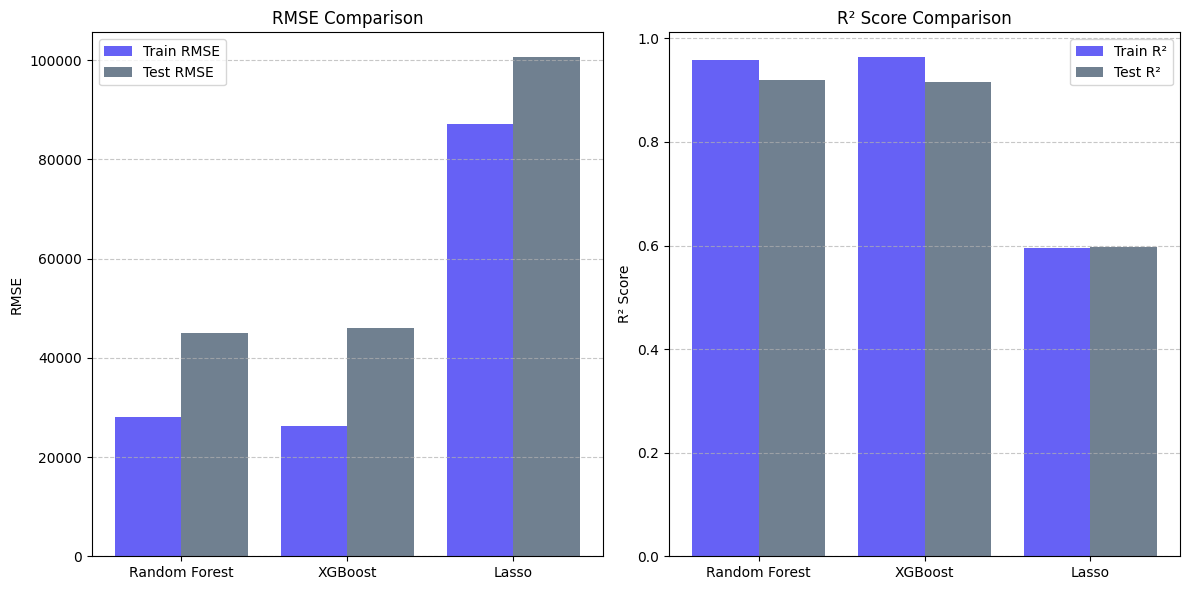

In [321]:
models = ['Random Forest', 'XGBoost', 'Lasso']

train_rmse = [rf_train_rmse, xgb_train_rmse, lr_train_rmse]  
test_rmse = [rf_test_rmse, xgb_test_rmse, lr_test_rmse]  

train_r2 = [rf_train_r2, xgb_train_r2, lr_train_r2]  
test_r2 = [rf_test_r2, xgb_test_r2, lr_test_r2]  


x = np.arange(len(models)) 

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].bar(x - 0.2, train_rmse, width=0.4, label="Train RMSE", color='#6661F5')
ax[0].bar(x + 0.2, test_rmse, width=0.4, label="Test RMSE", color='slategray')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].set_ylabel("RMSE")
ax[0].set_title("RMSE Comparison")
ax[0].legend()
ax[0].grid(axis="y", linestyle="--", alpha=0.7)


ax[1].bar(x - 0.2, train_r2, width=0.4, label="Train R²", color='#6661F5')
ax[1].bar(x + 0.2, test_r2, width=0.4, label="Test R²", color='slategray')
ax[1].set_xticks(x)
ax[1].set_xticklabels(models)
ax[1].set_ylabel("R² Score")
ax[1].set_title("R² Score Comparison")
ax[1].legend()
ax[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()